<a href="https://colab.research.google.com/github/amun83/Koscom-FinancialDataCamp/blob/master/mini_project_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q html5lib
!pip install -q lxml
!pip install -q pandas_datareader
!pip install -q finance-datareader
!pip install -q gspread

In [0]:
import requests
import datetime
import urllib.parse
import numpy as np
import pandas as pd
import re
import pandas_datareader as pdr
import FinanceDataReader as fdr

from IPython.display import display
from bs4 import BeautifulSoup
from pandas.plotting import scatter_matrix

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = True
plt.rcParams['figure.figsize'] = (21, 7)
plt.style.use("bmh")

##Sunsirs 데이터 스크래핑
* http://www.sunsirs.com/uk/sdetail.html
* 중국의 Daily Commodity 가격 수집
* FRED의 CNY/USD를 이용해 USD 가격 산출
* Google Drive에  cvs 파일로 저장

In [253]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
def scraping_sunsirs(path, op = "a", fr = None, to = None):
  if fr is None:
    fr = pd.datetime.now()
  if to is None:
    to = pd.datetime.now()
    
  df_CNYUSD = pdr.DataReader("DEXCHUS", "fred", fr, to)
  
  pattern   = re.compile(r'(\d{2})/(\d{2})/(\d{4})')  #22/10/2018
  
  with open(path, op) as f:
    for d in pd.date_range(fr, to, freq="D"):
      #getting html
      url = "http://www.sunsirs.com/uk/sdetail-day-" + d.strftime("%Y-%m%d") + ".html"
      r = requests.get(url)

      #parsing table
      dfs = pd.read_html(r.content, header=0)
      if dfs[0].empty:
        print("[ %s ] => No table found" % (url))
        continue
      df = dfs[0]

      #parsing date
      soup = BeautifulSoup(r.content, 'lxml')
      text = soup.find("div", {"class" : "name"}).text  #<div class="name">100 Spot Commodities Price Chart  - 22/10/2018  </div  
      match = re.search(pattern, text)
      dd, mm, yyyy = match.groups(0)
      spot_date = yyyy + "-" + mm + "-" + dd

      df.columns = ("Commodity", "Sectors", "Price_BFT", "Price_TDY", "Change")
      df["Date"] = spot_date
      df["URL"]  =  d.strftime("%Y-%m%d") + ".html"

      try:
        xr = df_CNYUSD.loc[spot_date, "DEXCHUS"]
        df["CNY_USD"]      = xr
        df["Price_USD_KG"] = df["Price_TDY"] / (xr * 1000)
      except:
        df["CNY_USD"]      = np.NaN
        df["Price_USD_KG"] = np.NaN

      df.to_csv(f, mode = op, columns = ("Date", "Commodity", "Sectors", "Price_TDY", "Change", "CNY_USD", "Price_USD_KG", "URL"), encoding = 'utf-8', index = False, header = False)
      print("[ %s ] => %d row dataframe added" % (url, len(dfs[0])))

In [42]:
scraping_sunsirs("/gdrive/My Drive/sunsirs_daily_test_20181101_demo.csv", "w", "2018-10-23")  #2016-01-01 ~ 2018-11-01

[ http://www.sunsirs.com/uk/sdetail-day-2018-1023.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1024.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1025.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1026.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1027.html ] => No table found
[ http://www.sunsirs.com/uk/sdetail-day-2018-1028.html ] => No table found
[ http://www.sunsirs.com/uk/sdetail-day-2018-1029.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1030.html ] => 100 row dataframe added
[ http://www.sunsirs.com/uk/sdetail-day-2018-1031.html ] => No table found
[ http://www.sunsirs.com/uk/sdetail-day-2018-1101.html ] => No table found


##Sunsirs 데이터 다시 읽기
 * Dataframe으로 가져오기
 * 이상한 데이터 없나 살펴보기 (중복, 주말, ...)
 * Polysilicon 가격만 남기기

In [255]:
with open("/gdrive/My Drive/sunsirs_daily_test_20181101.csv", "r") as f:
  df_sunsirs = pd.read_csv(f, header = None, names = ("Date", "Commodity", "Sectors", "Price_TDY", "Change", "CNY_USD", "Price_USD_KG", "URL"), index_col = "Date", parse_dates = True)
  
df_sunsirs.head()

,Commodity,Sectors,Price_TDY,Change,CNY_USD,Price_USD_KG,URL
Date,,,,,,,
2016-01-04,Benzene,Chemical,4390.00,4.52%,6.5338,0.671891,2016-0101.html
2016-01-04,Iron ore,Steel,340.56,3.03%,6.5338,0.052123,2016-0101.html
2016-01-04,Cold rolled sheet,Steel,2714.44,2.09%,6.5338,0.415446,2016-0101.html
2016-01-04,Bromine,Chemical,24791.67,1.36%,6.5338,3.794372,2016-0101.html
2016-01-04,Mild steel plate,Steel,1898.00,1.24%,6.5338,0.290489,2016-0101.html


In [256]:
df_sunsirs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74081 entries, 2016-01-04 to 2018-10-31
Data columns (total 7 columns):
Commodity       73583 non-null object
Sectors         74081 non-null object
Price_TDY       74081 non-null float64
Change          74081 non-null object
CNY_USD         70699 non-null float64
Price_USD_KG    70699 non-null float64
URL             74081 non-null object
dtypes: float64(3), object(4)
memory usage: 4.5+ MB


In [257]:
df_sunsirs.pivot_table(values = "Price_USD_KG", index = "Date", columns="Commodity", aggfunc="mean").head()

Commodity,2-EH,Acetic acid,Acetone,Acrylic acid,Activated charcoal,Adipic acid,Aluminum,Aniline,Asphalt,BR,...,Tin ingot,Titanium Dioxide,Toluene,Urea,Wheat,White granulated sugar,Wood pulp,Xylene,Zinc,corrugated paper
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.794331,0.285056,0.538227,0.834124,1.711868,0.847899,1.680875,0.828659,0.351746,1.217259,...,14.417338,1.668248,0.768121,0.217607,0.366505,0.826319,0.726989,0.774307,2.041882,NaN
2016-01-05,0.795780,0.284618,0.539209,0.835646,1.714991,0.849446,1.683558,0.830171,0.350583,1.229703,...,14.472393,1.671292,0.769523,0.217237,0.367174,0.827826,0.728315,0.775720,2.050208,NaN
2016-01-06,0.791714,0.283163,0.536454,0.832901,1.706227,0.845105,1.665421,0.828107,0.346998,1.223419,...,14.398435,1.665040,0.769404,0.216127,0.365297,0.821765,0.724593,0.769213,2.015705,NaN
2016-01-07,0.787246,0.281566,0.533427,0.828201,1.695841,0.840336,1.653748,0.823434,0.344058,1.216515,...,14.421473,1.659436,0.763166,0.214453,0.363236,0.817128,0.720505,0.767401,1.995609,NaN
2016-01-08,0.784141,0.281540,0.533378,0.828126,1.695686,0.840260,1.655114,0.832025,0.338673,1.216405,...,14.429640,1.661560,0.763097,0.214281,0.362798,0.817812,0.720439,0.767331,1.983293,NaN


In [258]:
df_sunsirs_ps = df_sunsirs[df_sunsirs["Commodity"] == "Polysilicon"]

dup_idx = df_sunsirs_ps.index.get_duplicates()
df_sunsirs_ps.loc[dup_idx, :]

,Commodity,Sectors,Price_TDY,Change,CNY_USD,Price_USD_KG,URL
Date,,,,,,,
2016-03-28,Polysilicon,Chemical,122016.67,0.00%,6.5051,18.757078,2016-0325.html
2016-03-28,Polysilicon,Chemical,122016.67,0.00%,6.5051,18.757078,2016-0327.html
2016-05-02,Polysilicon,Chemical,131333.33,0.00%,6.4738,20.286900,2016-0429.html
2016-05-02,Polysilicon,Chemical,131333.33,0.00%,6.4738,20.286900,2016-0501.html
2016-11-28,Polysilicon,Chemical,130333.33,0.00%,6.9055,18.873844,2016-1125.html
2016-11-28,Polysilicon,Chemical,130333.33,0.00%,6.9055,18.873844,2016-1127.html
2017-02-27,Polysilicon,Chemical,139400.00,0.00%,6.8675,20.298507,2017-0224.html
2017-02-27,Polysilicon,Chemical,139400.00,0.00%,6.8675,20.298507,2017-0226.html


In [0]:
dup_idx = df_sunsirs_ps.index.get_duplicates()
df_sunsirs_ps= df_sunsirs_ps.drop(dup_idx)

dup_idx = df_sunsirs_ps.index.get_duplicates()

In [260]:
dt_sun = pd.date_range(df_sunsirs_ps.index.min(), df_sunsirs_ps.index.max(), freq="W-SUN")
dt_sat = pd.date_range(df_sunsirs_ps.index.min(), df_sunsirs_ps.index.max(), freq="W-SAT")
weekends = dt_sun.union(dt_sat)
weekends



DatetimeIndex(['2016-01-09', '2016-01-10', '2016-01-16', '2016-01-17',
               '2016-01-23', '2016-01-24', '2016-01-30', '2016-01-31',
               '2016-02-06', '2016-02-07',
               ...
               '2018-09-29', '2018-09-30', '2018-10-06', '2018-10-07',
               '2018-10-13', '2018-10-14', '2018-10-20', '2018-10-21',
               '2018-10-27', '2018-10-28'],
              dtype='datetime64[ns]', length=294, freq=None)

In [261]:
wkd_idx = [di for di in df_sunsirs_ps.index if di in weekends]
df_sunsirs_ps.loc[wkd_idx, :]

,Commodity,Sectors,Price_TDY,Change,CNY_USD,Price_USD_KG,URL
Date,,,,,,,
2016-09-18,Polysilicon,Chemical,125166.67,0.00%,NaN,NaN,2016-0917.html
2017-01-01,Polysilicon,Chemical,136833.33,0.00%,NaN,NaN,2016-1231.html
2017-04-02,Polysilicon,Chemical,129800.00,0.00%,NaN,NaN,2017-0401.html
2018-09-29,Polysilicon,Chemical,95000.00,0.00%,NaN,NaN,2018-0928.html


##PV Insights 데이터 읽어오기

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
worksheet = gc.open("pvinsights_weekly").sheet1

df_pvinsights = pd.DataFrame.from_records(worksheet.get_all_values(), columns = ("Date", "Price"), index = "Date",)
df_pvinsights.index = pd.to_datetime(df_pvinsights.index)
df_pvinsights["Price"] = np.float64(df_pvinsights["Price"])

In [264]:
display(df_pvinsights.head(5))

,Price
Date,
2016-01-06,13.07
2016-01-13,13.01
2016-01-20,12.94
2016-01-27,12.93
2016-02-03,12.93


In [265]:
polysi = pd.DataFrame()
polysi["Date"] = pd.date_range("2016-01-01", pd.datetime.now(), freq="D")
polysi.set_index("Date", inplace = True)
polysi.head(5)

""
Date
2016-01-01
2016-01-02
2016-01-03
2016-01-04
2016-01-05


In [266]:
df_sunsirs_ps.index.is_unique

True

In [267]:
polysi = pd.concat([polysi, df_pvinsights, df_sunsirs_ps[["Price_USD_KG", "Price_TDY", "CNY_USD"]]], axis = 1)
polysi.columns = ("PVInsights", "Sunsirs", "Sunsirs_CNY", "CNY_USD")
polysi.head(5)

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD
Date,,,,
2016-01-01,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN
2016-01-04,NaN,17.182447,112266.67,6.5338
2016-01-05,NaN,17.208686,112233.33,6.5219


In [268]:
polysi.head(5)

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD
Date,,,,
2016-01-01,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN
2016-01-04,NaN,17.182447,112266.67,6.5338
2016-01-05,NaN,17.208686,112233.33,6.5219


In [269]:
polysi = polysi.interpolate()
polysi.head(30)

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD
Date,,,,
2016-01-01,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN
2016-01-04,NaN,17.182447,112266.67,6.533800
2016-01-05,NaN,17.208686,112233.33,6.521900
2016-01-06,13.070000,17.120745,112233.33,6.555400
2016-01-07,13.061429,16.981161,111950.00,6.592600
2016-01-08,13.052857,16.979615,111950.00,6.593200
2016-01-09,13.044286,17.001764,111950.00,6.584633


In [270]:
polysi.dropna()

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD
Date,,,,
2016-01-06,13.070000,17.120745,112233.33,6.555400
2016-01-07,13.061429,16.981161,111950.00,6.592600
2016-01-08,13.052857,16.979615,111950.00,6.593200
2016-01-09,13.044286,17.001764,111950.00,6.584633
2016-01-10,13.035714,17.023912,111950.00,6.576067
2016-01-11,13.027143,17.046060,111950.00,6.567500
2016-01-12,13.018571,17.037037,111933.33,6.570000
2016-01-13,13.010000,17.037037,111933.33,6.570000
2016-01-14,13.000000,16.987651,111933.33,6.589100


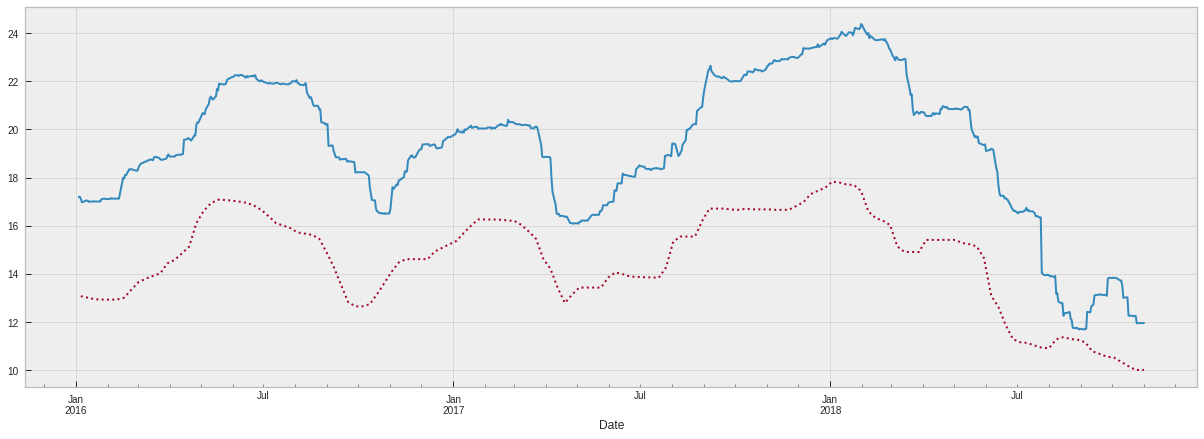

In [271]:
plt.figure()
polysi["Sunsirs"].plot(style = "-")
polysi["PVInsights"].plot(style = ":")


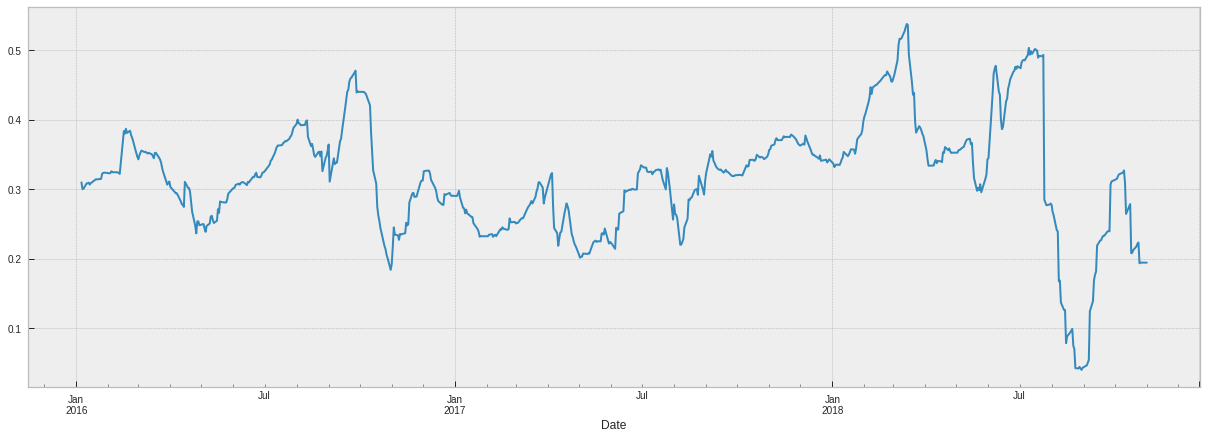

In [272]:
plt.figure()
diff_ratio = (polysi["Sunsirs"] - polysi["PVInsights"]) / polysi["PVInsights"]
diff_ratio.plot(style = "-")

In [273]:
diff_ratio.describe()

count    1031.000000
mean        0.316913
std         0.082624
min         0.039804
25%         0.265667
50%         0.320549
75%         0.357642
max         0.538106
dtype: float64

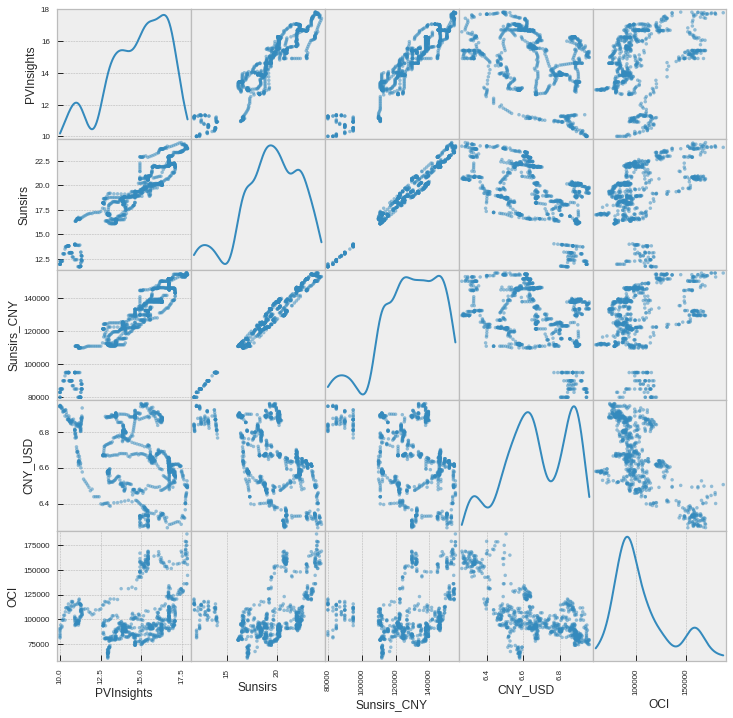

In [282]:
_ = scatter_matrix(polysi, diagonal='kde', figsize=(12, 12))

In [275]:
polysi.corr()

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD
PVInsights,1.000000,0.934037,0.947414,-0.382450
Sunsirs,0.934037,1.000000,0.984631,-0.553272
Sunsirs_CNY,0.947414,0.984631,1.000000,-0.401605
CNY_USD,-0.382450,-0.553272,-0.401605,1.000000


In [276]:
df = fdr.DataReader("010060", "2016-01-01", pd.datetime.now())
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-10', '2016-01-11',
               '2016-01-12', '2016-01-13',
               ...
               '2018-10-19', '2018-10-22', '2018-10-23', '2018-10-24',
               '2018-10-25', '2018-10-26', '2018-10-29', '2018-10-30',
               '2018-10-31', '2018-11-01'],
              dtype='datetime64[ns]', name='Date', length=809, freq=None)

In [277]:
polysi["OCI"] = df["Close"]
polysi.head(10)

,PVInsights,Sunsirs,Sunsirs_CNY,CNY_USD,OCI
Date,,,,,
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,75000.0
2016-01-04,NaN,17.182447,112266.67,6.533800,72700.0
2016-01-05,NaN,17.208686,112233.33,6.521900,73600.0
2016-01-06,13.070000,17.120745,112233.33,6.555400,73400.0
2016-01-07,13.061429,16.981161,111950.00,6.592600,71600.0
2016-01-08,13.052857,16.979615,111950.00,6.593200,71700.0
2016-01-09,13.044286,17.001764,111950.00,6.584633,NaN


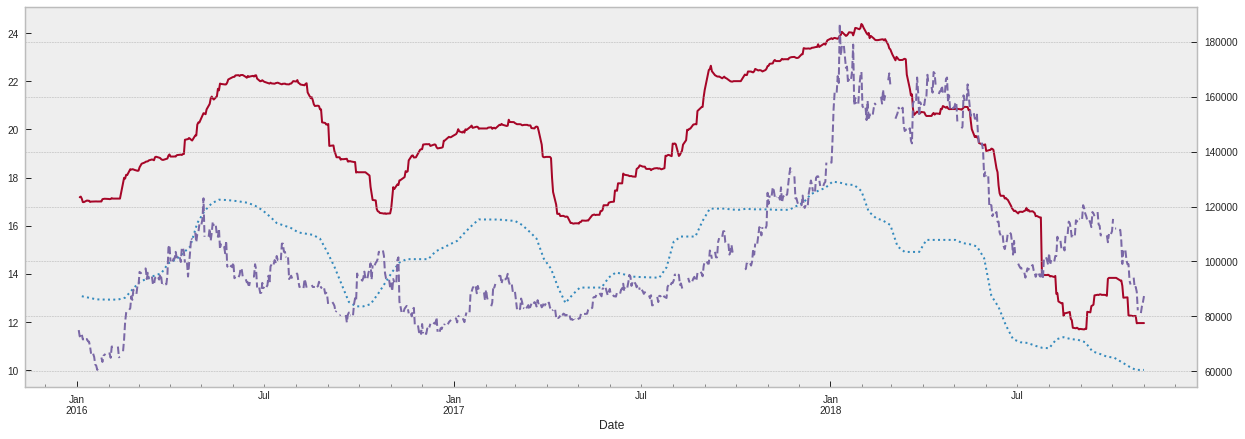

In [280]:
plt.figure()
polysi["PVInsights"].plot(style = ":")
polysi["Sunsirs"].plot(style = "-")
polysi["OCI"].plot(style = "--", secondary_y = True)



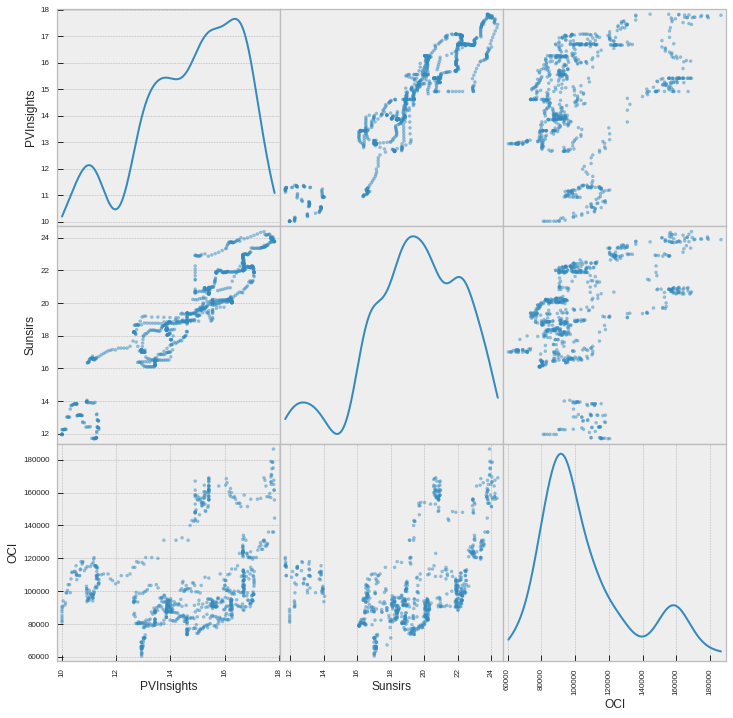

In [284]:
polysi_oci = polysi[["PVInsights", "Sunsirs", "OCI"]]
_ = scatter_matrix(polysi_oci, diagonal='kde', figsize=(12, 12))

In [285]:
polysi_oci.corr()

,PVInsights,Sunsirs,OCI
PVInsights,1.000000,0.934037,0.326525
Sunsirs,0.934037,1.000000,0.425317
OCI,0.326525,0.425317,1.000000


In [0]:
polysi_oci_1617 = polysi_oci.loc[:"2017-12-31", :]

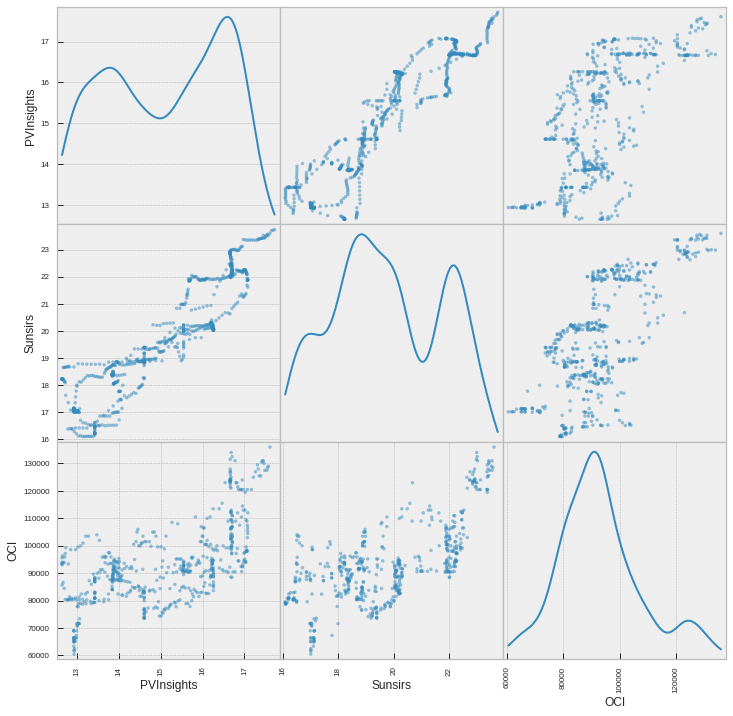

In [288]:
_ = scatter_matrix(polysi_oci_1617, diagonal='kde', figsize=(12, 12))

In [289]:
polysi_oci_1617.corr()

,PVInsights,Sunsirs,OCI
PVInsights,1.000000,0.923686,0.651616
Sunsirs,0.923686,1.000000,0.693442
OCI,0.651616,0.693442,1.000000
